In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation

import os

from util.register import register

from skimage.transform import resize

import suite2p

In [2]:
# movie_path = (r"C:\Users\zfj\data\100522B\region1_00001.tif", r"C:\Users\zfj\data\100522B\region1_00002.tif", r"C:\Users\zfj\data\100522B\region2_00001.tif")
# stack_path = (r"C:\Users\zfj\data\100522B\region1_stack_00002.tif", r"C:\Users\zfj\data\100522B\region1_stack_00002.tif", r"C:\Users\zfj\data\100522B\region2_stack_00001.tif")
# out_path = (r"C:\Users\zfj\data\100522B\region1_00001", r"C:\Users\zfj\data\100522B\region1_00002", r"C:\Users\zfj\data\100522B\region2_00001")


g_file = r"C:\Users\zfj\data\101222B\region2\suite2p\plane0\data.bin"
r_file = r"C:\Users\zfj\data\101222B\region2\suite2p\plane0\data_chan2.bin"
mask_file = r"C:\Users\zfj\data\101222B\region2\101222B_region2_18_masks.tif"
stack_file = r"C:\Users\zfj\data\101222B\region2\region2_stack_00002.tif"

In [43]:
r_dat = suite2p.io.BinaryRWFile(32,128, r_file).data
g_dat = suite2p.io.BinaryRWFile(32,128, g_file).data
m = suite2p.io.tiff.open_tiff(mask_file, True)[0].pages[0].asarray()
stack,_ = suite2p.io.tiff.open_tiff(stack_file,sktiff=0)
stack = stack.data().reshape(-1,3,4,256,256)[:,:,0,:,:].mean(axis=1)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [4]:
def register_frames(refAndMasks, frames, rmin=-np.inf, rmax=np.inf, bidiphase=0, ops=suite2p.default_ops(), nZ=1):
    """ register frames to reference image 
    
    Parameters
    ----------
    refAndMasks : list of processed reference images and masks, or 2D array of reference image
    frames : np.ndarray, np.int16 or np.float32
        time x Ly x Lx
    rmin : clip frames at rmin
    rmax : clip frames at rmax
    Returns
    --------
    ops : dictionary
        'nframes', 'yoff', 'xoff', 'corrXY', 'yoff1', 'xoff1', 'corrXY1', 'badframes'
    """

    if nZ > 1:
        cmax_best = -np.inf * np.ones(len(frames), 'float32')
        cmax_all = -np.inf * np.ones((len(frames), nZ), 'float32')
        zpos_best = np.zeros(len(frames), 'int')
        for z in range(nZ):
            ops['nonrigid'] = False
            outputs = register_frames(refAndMasks[z], frames.copy(), rmin=rmin[z], rmax=rmax[z], 
                                        bidiphase=bidiphase, ops=ops, nZ=1)
            cmax_all[:,z] = outputs[3]
            if z==0:
                outputs_best = list(outputs[:-1]).copy() 
            ibest = cmax_best < cmax_all[:,z]
            zpos_best[ibest] = z
            cmax_best[ibest] = cmax_all[ibest, z]
            for i, (output_best, output) in enumerate(zip(outputs_best, outputs[:-1])):
                output_best[ibest] = output[ibest]
        frames, ymax, xmax, cmax = outputs_best
        return frames, ymax, xmax, cmax, (zpos_best, cmax_all)
    else:    
        if len(refAndMasks)==7 or not isinstance(refAndMasks, np.ndarray):
            maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR, blocks = refAndMasks 
        else:
            refImg = refAndMasks
            if ops.get('norm_frames', False) and 'rmin' not in ops:
                rmin, rmax = np.int16(np.percentile(refImg,1)), np.int16(np.percentile(refImg,99))
                refImg = np.clip(refImg, rmin, rmax)
            maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR, blocks = suite2p.registration.register.compute_reference_masks(refImg, ops)
        
        if bidiphase != 0:
            suite2p.registration.register.bidi.shift(frames, bidiphase)

        
        # if smoothing or filtering or clipping to compute registration shifts, make a copy of the frames
        dtype = 'float32' if ops['smooth_sigma_time'] > 0 or ops['1Preg'] else frames.dtype
        fsmooth = frames.copy().astype(dtype) if ops['smooth_sigma_time'] > 0 or ops['1Preg'] else frames
        
        if ops['smooth_sigma_time']:
            fsmooth = suite2p.registration.utils.temporal_smooth(data=fsmooth, sigma=ops['smooth_sigma_time'])
        else:
            fsmooth = frames

        # preprocessing for 1P recordings
        if ops['1Preg']:
            if ops['pre_smooth']:
                fsmooth = suite2p.registration.utils.spatial_smooth(fsmooth, int(ops['pre_smooth']))
            fsmooth = suite2p.registration.utils.spatial_high_pass(fsmooth, int(ops['spatial_hp_reg']))

        # rigid registration
        ymax, xmax, cmax = suite2p.registration.register.rigid.phasecorr(
            data=suite2p.registration.register.rigid.apply_masks(data=np.clip(fsmooth, rmin, rmax) if rmin>-np.inf else fsmooth, 
                                    maskMul=maskMul, maskOffset=maskOffset),
            cfRefImg=cfRefImg,
            maxregshift=ops['maxregshift'],
            smooth_sigma_time=ops['smooth_sigma_time'],
        )
        
        for frame, dy, dx in zip(frames, ymax, xmax):
            frame[:] = suite2p.registration.register.rigid.shift_frame(frame=frame, dy=dy, dx=dx)
        
        
        return frames, ymax, xmax, cmax, None

In [5]:
def compute_reference_masks(refImg, ops=suite2p.default_ops()):
    ### ------------- compute registration masks ----------------- ###
    if isinstance(refImg, list):
        refAndMasks_all = []
        for rimg in refImg:
            refAndMasks = compute_reference_masks(rimg, ops)
            refAndMasks_all.append(refAndMasks)
        return refAndMasks_all
    else:
        maskMul, maskOffset = suite2p.registration.rigid.compute_masks(
            refImg=refImg,
            maskSlope=ops['spatial_taper'] if ops['1Preg'] else 3 * ops['smooth_sigma'],
        )
        cfRefImg = suite2p.registration.rigid.phasecorr_reference(
            refImg=refImg,
            smooth_sigma=ops['smooth_sigma'],
        )
        Ly, Lx = refImg.shape
        if ops.get('nonrigid'):
            blocks = suite2p.registration.nonrigid.make_blocks(Ly=Ly, Lx=Lx, block_size=ops['block_size'])

            maskMulNR, maskOffsetNR, cfRefImgNR = suite2p.registration.nonrigid.phasecorr_reference(
                refImg0=refImg,
                maskSlope=ops['spatial_taper'] if ops['1Preg'] else 3 * ops['smooth_sigma'], # slope of taper mask at the edges
                smooth_sigma=ops['smooth_sigma'],
                yblock=blocks[0],
                xblock=blocks[1],
            )
        else:
            maskMulNR, maskOffsetNR, cfRefImgNR, blocks = [], [], [], []

        return maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR, blocks

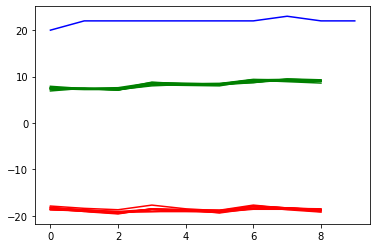

<Figure size 432x288 with 0 Axes>

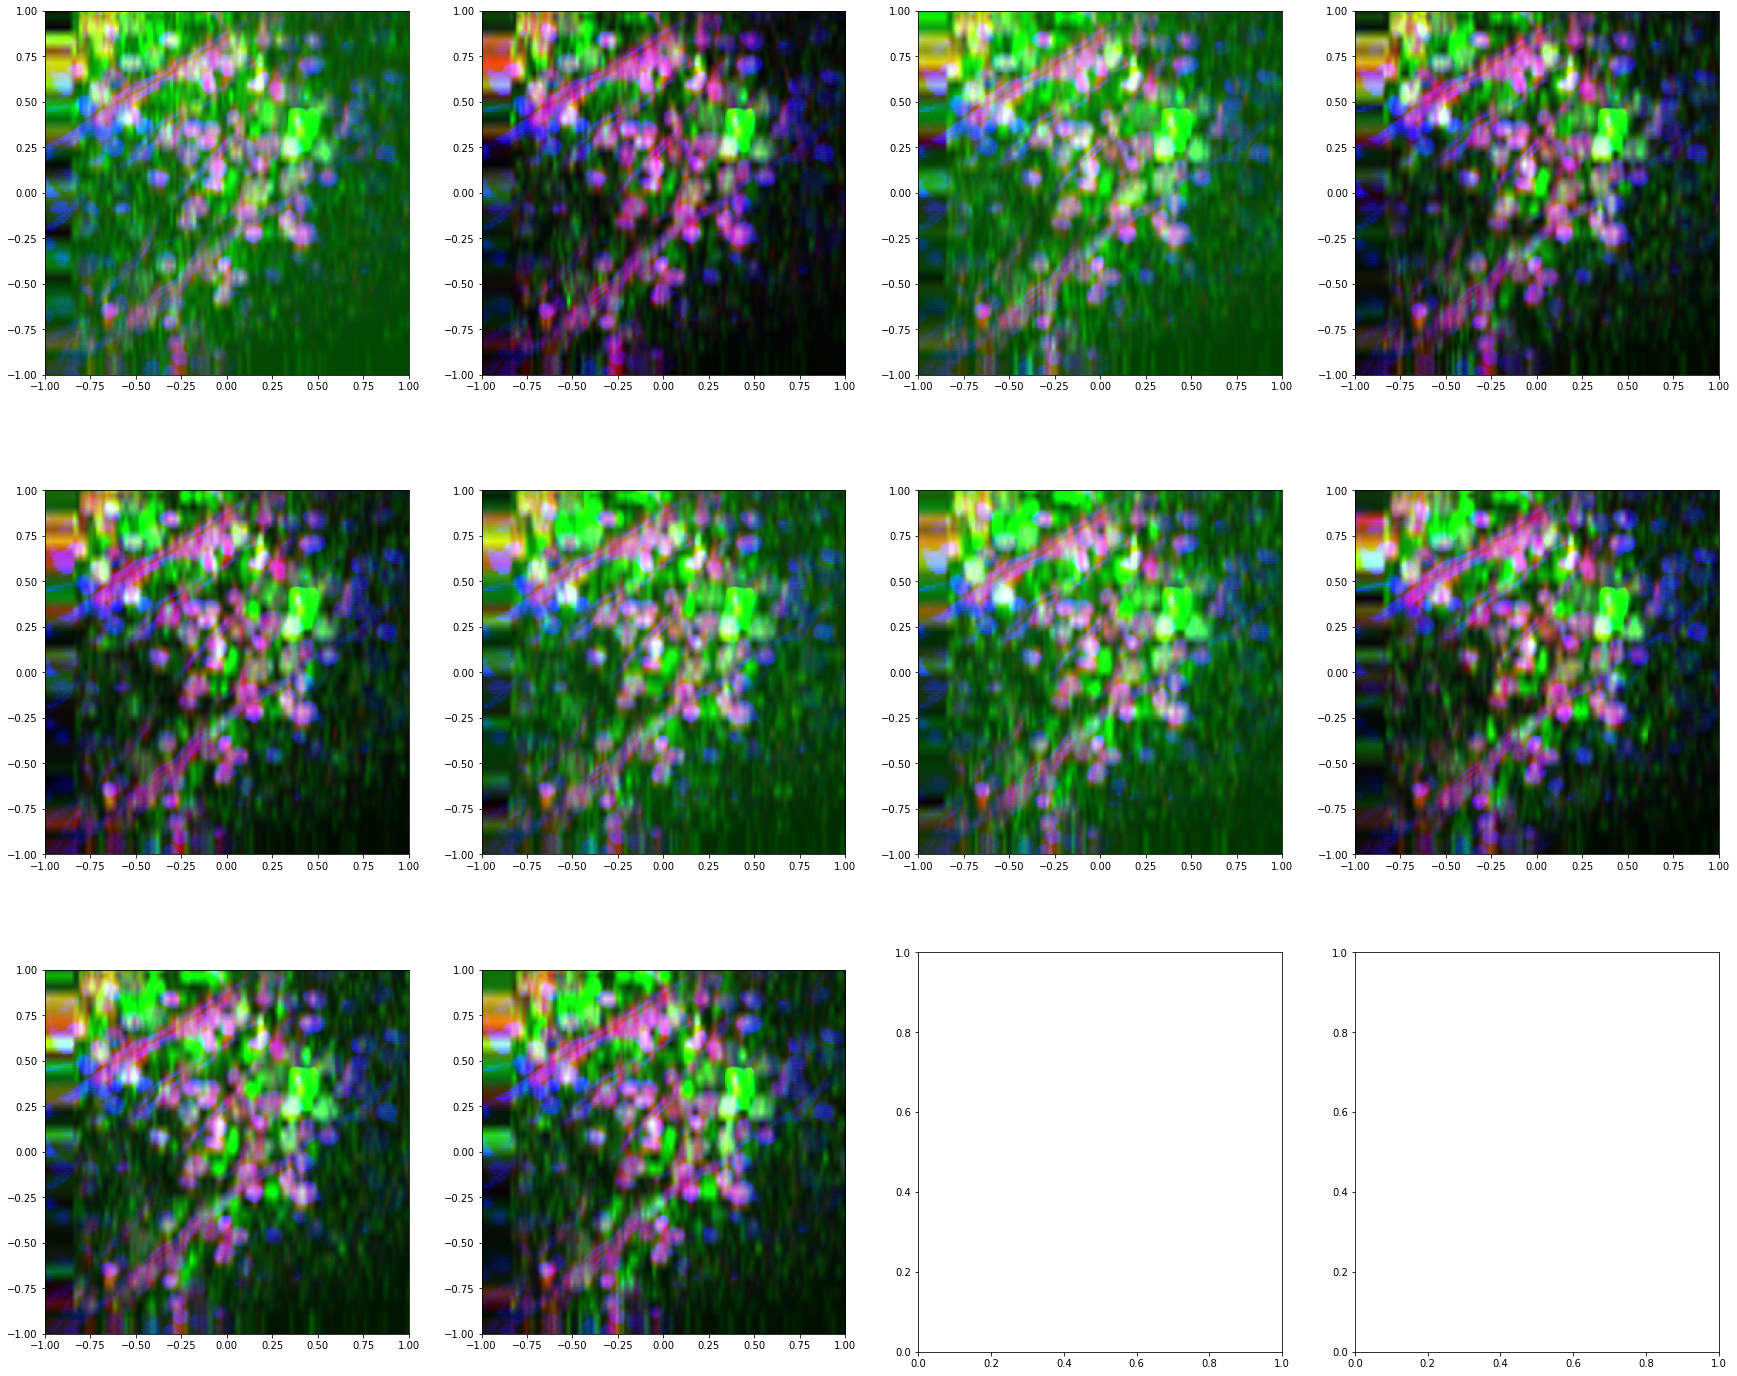

In [55]:
#setup
nr,rmin,rmax = suite2p.registration.register.normalize_reference_image([plane for plane in stack])
ops = suite2p.default_ops()
batch_size=10

outputs = compute_reference_masks(nr, ops=ops)
maskMul, maskOffset, cfRefImg, maskMulNR, maskOffsetNR, cfRefImgNR, blocks = list(map(list, zip(*outputs)))
blocks_ds = [([y // 8 for y in z[0]], [x // 2 for x in z[1]]) for z in blocks]
#main loop:

#upsampling the data works much, much better than downsampling the stack; but is far slower
batch = resize(r_dat[:batch_size],(batch_size,256,256), preserve_range=True).astype(np.int16)

outputs = suite2p.registration.register.register_frames(outputs, batch, rmin=rmin, rmax=rmax, nZ=len(stack), ops=ops)
frames, yoff_r, xoff_r, cmax_r, yoff, xoff, cmax, (zoff, zcmax) = outputs

## can batch this by unique zoff?
g_out = g_dat[:batch_size].copy()
for frame,g,x,y,z,x_r,y_r in zip(batch, g_out, xoff, yoff, zoff, xoff_r, yoff_r):
    #this appears to work better than the built-in pipeline
    frame[:] = suite2p.registration.nonrigid.transform_data( 
        data=frame.reshape(-1,256,256),
        yblock=blocks[z][0],
        xblock=blocks[z][1],
        nblocks=blocks[z][2],
        ymax1=y[None, :] + y_r,
        xmax1=x[None, :] + x_r,
    )
    
    g[:] = suite2p.registration.nonrigid.transform_data( # func channel register
        data=g.reshape(-1,32,128),
        yblock = blocks_ds[z][0],
        xblock = blocks_ds[z][1],
        nblocks=blocks[z][2],
        ymax1=(y[None, :] + y_r) / 8,
        xmax1=(x[None, :] + x_r) / 2,
    )

#write frames to file

#close:
#write y,x,z,c/zc to file <- in particular, we need these to mask bad pix


#30sec / 500 frames



In [ ]:

plt.plot(xoff.T + xoff_r[None, :], color='r')
plt.plot(yoff.T + yoff_r[None, :], color= 'g')
plt.plot(zoff, color='b')

plt.figure()
_,axs = plt.subplots(int(np.ceil(len(batch)/4)), 4,figsize=(30,25))
axs = axs.flatten()
for i in range(len(batch)):
    s = stack[zoff[i]].copy()
    s = s - s.min()
    s = s / s.max()

    # f = frames[i]
    f = batch[i].copy()
    f = f - f.min()
    f = f / f.max()

    g = resize(g_out[i],(256,256))
    g = g - g.min()
    g = np.clip(g / g.max() * 10, 0, 1)

    # if xoff[i] < 0:
    #     f[:,:-xoff[i]] = np.nan
    # else:
    #     f[:,-xoff[i]:] = np.nan # TODO: double check these :)
    # if yoff[i] < 0:
    #     f[:-yoff[i],:] = np.nan
    # else:
    #     f[-yoff[i]:,:] = np.nan # TODO: double check these :)


    reg = np.stack((
        f,
        g,
        s,
    ), axis=2)
    axs[i].imshow(reg, extent=np.array([-1,1,-1,1]))
plt.show()


In [59]:
print([o.shape if type(o)==np.ndarray else len(o) for o in outputs])
print([o.shape for o in outputs[-1]])


[(10, 256, 256), (10,), (10,), (10,), (10, 9), (10, 9), (10, 9), 2]
[(10,), (10, 43)]


In [ ]:

plt.figure()
_,axs = plt.subplots(int(np.ceil(len(batch)/4)), 4,figsize=(30,25))
axs = axs.flatten()
for i in range(len(batch)):
    s = stack[zoff[i]].copy()
    s = s - s.min()
    s = s / s.max()

    # f = frames[i]
    f = batch[i].copy()
    f = f - f.min()
    f = f / f.max()

    g = resize(g_out[i],(256,256))
    g = g - g.min()
    g = np.clip(g / g.max() * 10, 0, 1)

    # if xoff[i] < 0:
    #     f[:,:-xoff[i]] = np.nan
    # else:
    #     f[:,-xoff[i]:] = np.nan # TODO: double check these :)
    # if yoff[i] < 0:
    #     f[:-yoff[i],:] = np.nan
    # else:
    #     f[-yoff[i]:,:] = np.nan # TODO: double check these :)


    reg = np.stack((
        f,
        g,
        s,
    ), axis=2)
    axs[i].imshow(reg, extent=np.array([-1,1,-1,1]))
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

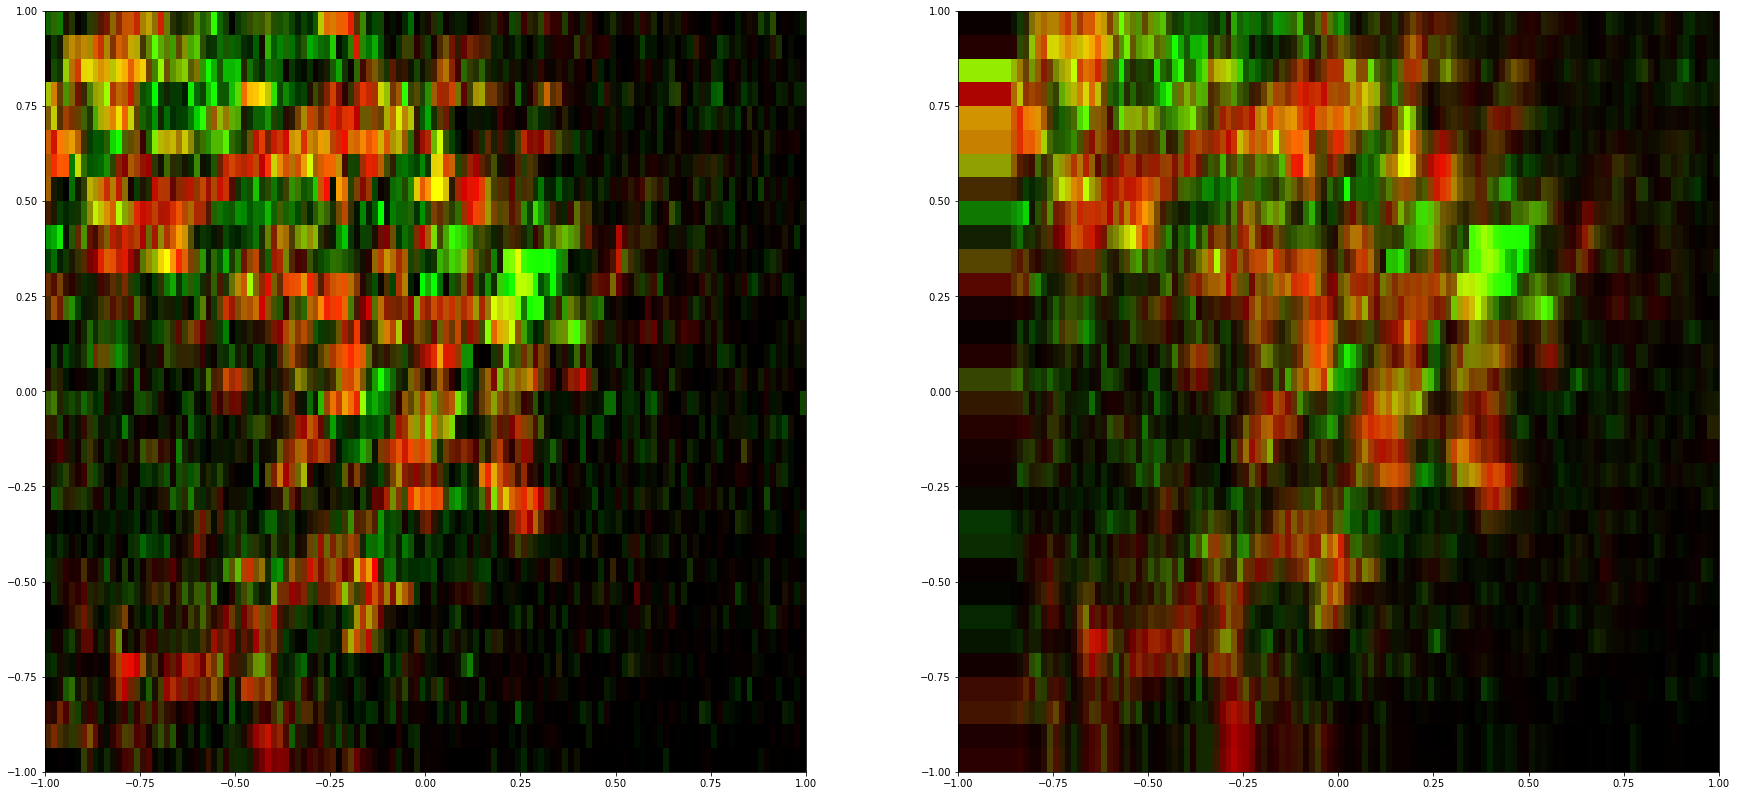

In [56]:
plt.figure()
_,axs = plt.subplots(1,2,figsize=(30,25))
axs = axs.flatten()

f = r_dat[0].copy()
f = f - f.min()
f = f / f.max()

g = g_dat[0].copy()
# g = g - g.min()
g = np.clip(g / g.max() * 10, 0, 1)

unreg = np.stack((
    f,
    g,
    np.zeros_like(f),
), axis=2)
axs[0].imshow(unreg, extent=np.array([-1,1,-1,1]))

f = resize(batch[0],(32,128))
f = f - f.min()
f = f / f.max()

# g = resize(g_out[0],(256,256))
g = g_out[0].copy()
# g = g - g.min()
g = np.clip(g / g.max() * 10, 0, 1)

reg = np.stack((
    f,
    g,
    np.zeros_like(f),
), axis=2)
axs[1].imshow(reg, extent=np.array([-1,1,-1,1]))



plt.show()

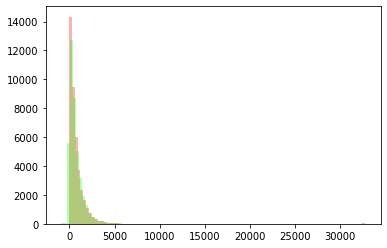

In [46]:
plt.hist(g_dat[:batch_size].flatten(), bins=100, fc=(1,0,0,.3))
plt.hist(g_out[:batch_size].flatten(), bins=100, fc=(0,1,0,.3))

plt.show()

In [101]:
ops = suite2p.default_ops()
ops['batch_size']

500

tif
** Found 1 tifs - converting to binary **
2000 frames of binary, time 7.66 sec.
4000 frames of binary, time 7.67 sec.
6000 frames of binary, time 7.69 sec.
8000 frames of binary, time 7.71 sec.
10000 frames of binary, time 7.71 sec.
12000 frames of binary, time 7.75 sec.
14000 frames of binary, time 7.76 sec.
16000 frames of binary, time 7.78 sec.
18000 frames of binary, time 7.80 sec.
20000 frames of binary, time 7.82 sec.
22000 frames of binary, time 7.83 sec.
24000 frames of binary, time 7.85 sec.
26000 frames of binary, time 7.87 sec.
28000 frames of binary, time 7.88 sec.
30000 frames of binary, time 7.90 sec.
32000 frames of binary, time 7.91 sec.
34000 frames of binary, time 7.93 sec.
36000 frames of binary, time 7.95 sec.
38000 frames of binary, time 7.96 sec.
40000 frames of binary, time 7.98 sec.
42000 frames of binary, time 7.99 sec.
44000 frames of binary, time 8.01 sec.
46000 frames of binary, time 8.02 sec.
48000 frames of binary, time 8.04 sec.
50000 frames of binary

c:\Users\zfj\anaconda3\envs\suite2p\lib\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
MovieWriter ffmpeg unavailable; using Pillow instead.


tif
** Found 1 tifs - converting to binary **
2000 frames of binary, time 11.58 sec.
4000 frames of binary, time 11.60 sec.
6000 frames of binary, time 11.63 sec.
8000 frames of binary, time 11.65 sec.
10000 frames of binary, time 11.68 sec.
12000 frames of binary, time 11.70 sec.
14000 frames of binary, time 11.72 sec.
16000 frames of binary, time 11.75 sec.
18000 frames of binary, time 11.77 sec.
20000 frames of binary, time 11.80 sec.
22000 frames of binary, time 11.83 sec.
24000 frames of binary, time 11.85 sec.
26000 frames of binary, time 11.88 sec.
28000 frames of binary, time 11.91 sec.
30000 frames of binary, time 11.93 sec.
32000 frames of binary, time 11.96 sec.
34000 frames of binary, time 11.99 sec.
36000 frames of binary, time 12.01 sec.
38000 frames of binary, time 12.04 sec.
40000 frames of binary, time 12.06 sec.
42000 frames of binary, time 12.08 sec.
44000 frames of binary, time 12.11 sec.
46000 frames of binary, time 12.14 sec.
48000 frames of binary, time 12.16 sec

c:\Users\zfj\anaconda3\envs\suite2p\lib\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
MovieWriter ffmpeg unavailable; using Pillow instead.


tif
** Found 1 tifs - converting to binary **
2000 frames of binary, time 18.02 sec.
4000 frames of binary, time 18.05 sec.
6000 frames of binary, time 18.07 sec.
8000 frames of binary, time 18.10 sec.
10000 frames of binary, time 18.12 sec.
12000 frames of binary, time 18.14 sec.
14000 frames of binary, time 18.17 sec.
16000 frames of binary, time 18.19 sec.
18000 frames of binary, time 18.22 sec.
20000 frames of binary, time 18.24 sec.
22000 frames of binary, time 18.27 sec.
24000 frames of binary, time 18.29 sec.
26000 frames of binary, time 18.32 sec.
28000 frames of binary, time 18.34 sec.
30000 frames of binary, time 18.36 sec.
32000 frames of binary, time 18.39 sec.
34000 frames of binary, time 18.41 sec.
36000 frames of binary, time 18.44 sec.
38000 frames of binary, time 18.46 sec.
40000 frames of binary, time 18.49 sec.
42000 frames of binary, time 18.51 sec.
44000 frames of binary, time 18.54 sec.
46000 frames of binary, time 18.56 sec.
48000 frames of binary, time 18.59 sec

c:\Users\zfj\anaconda3\envs\suite2p\lib\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
MovieWriter ffmpeg unavailable; using Pillow instead.


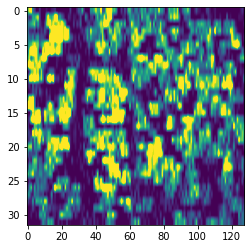

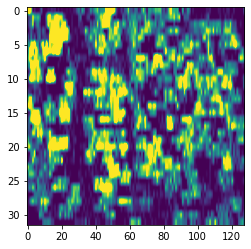

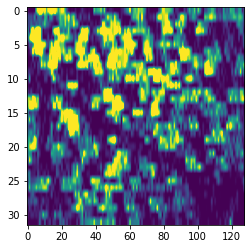

In [3]:
for m,s,o in zip(movie_path, stack_path, out_path):
    register(m,s,o)

[38, 38, 38, 32, 3, 3, 2, 32, 16135, 2, 2]


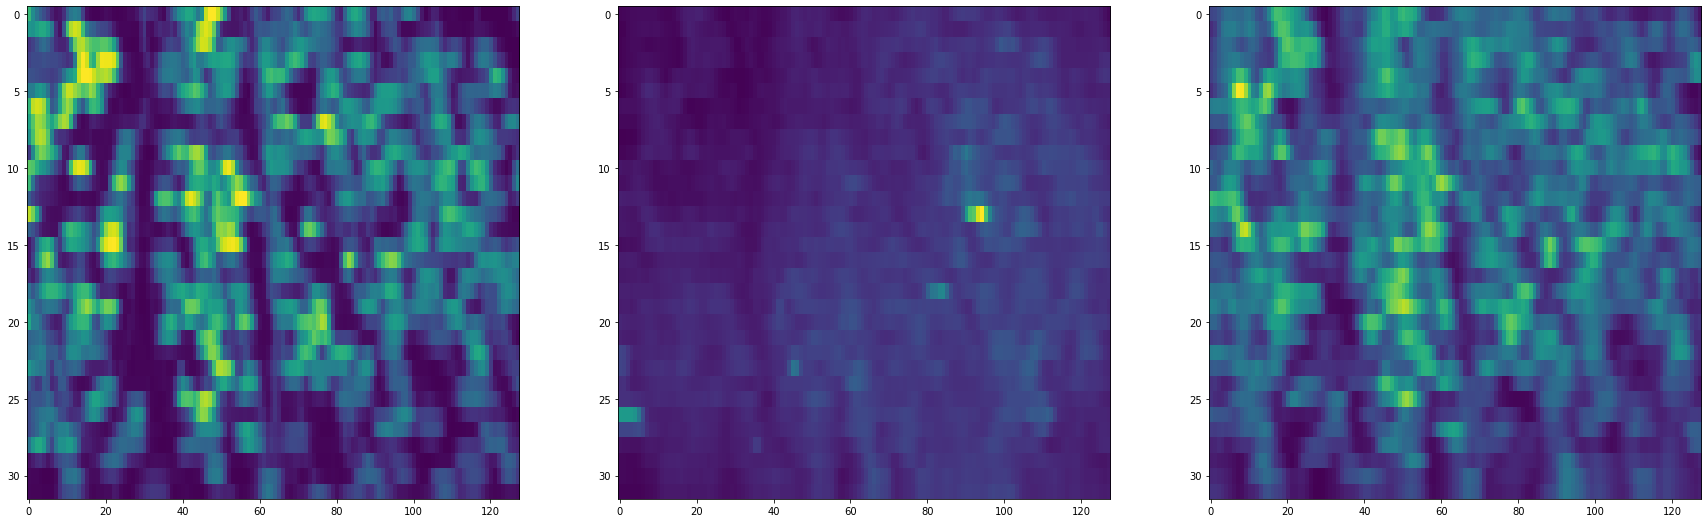

In [10]:
outputs = np.load(os.path.join(out_path[0], 'ops.npy'), allow_pickle=True)

print([(o.shape,) if type(o)==np.array else len(o) for o in outputs])

fig,axs = plt.subplots(1,3,figsize=(30,15))
axs[0].imshow(np.array(outputs[0]).mean(axis=0), aspect=4)
axs[1].imshow(np.array(outputs[3]), aspect=4)
axs[2].imshow(np.array(outputs[7]), aspect=4)
# plt.plot(outputs[6][0])
# outputs[6]

# print(np.array(outputs[3]).shape)
# plt.imshow(outputs[0][0], aspect=1/4)
# plt.imshow(np.array(outputs[3]), aspect=4)

# plt.plot(np.array(outputs[4]).T)


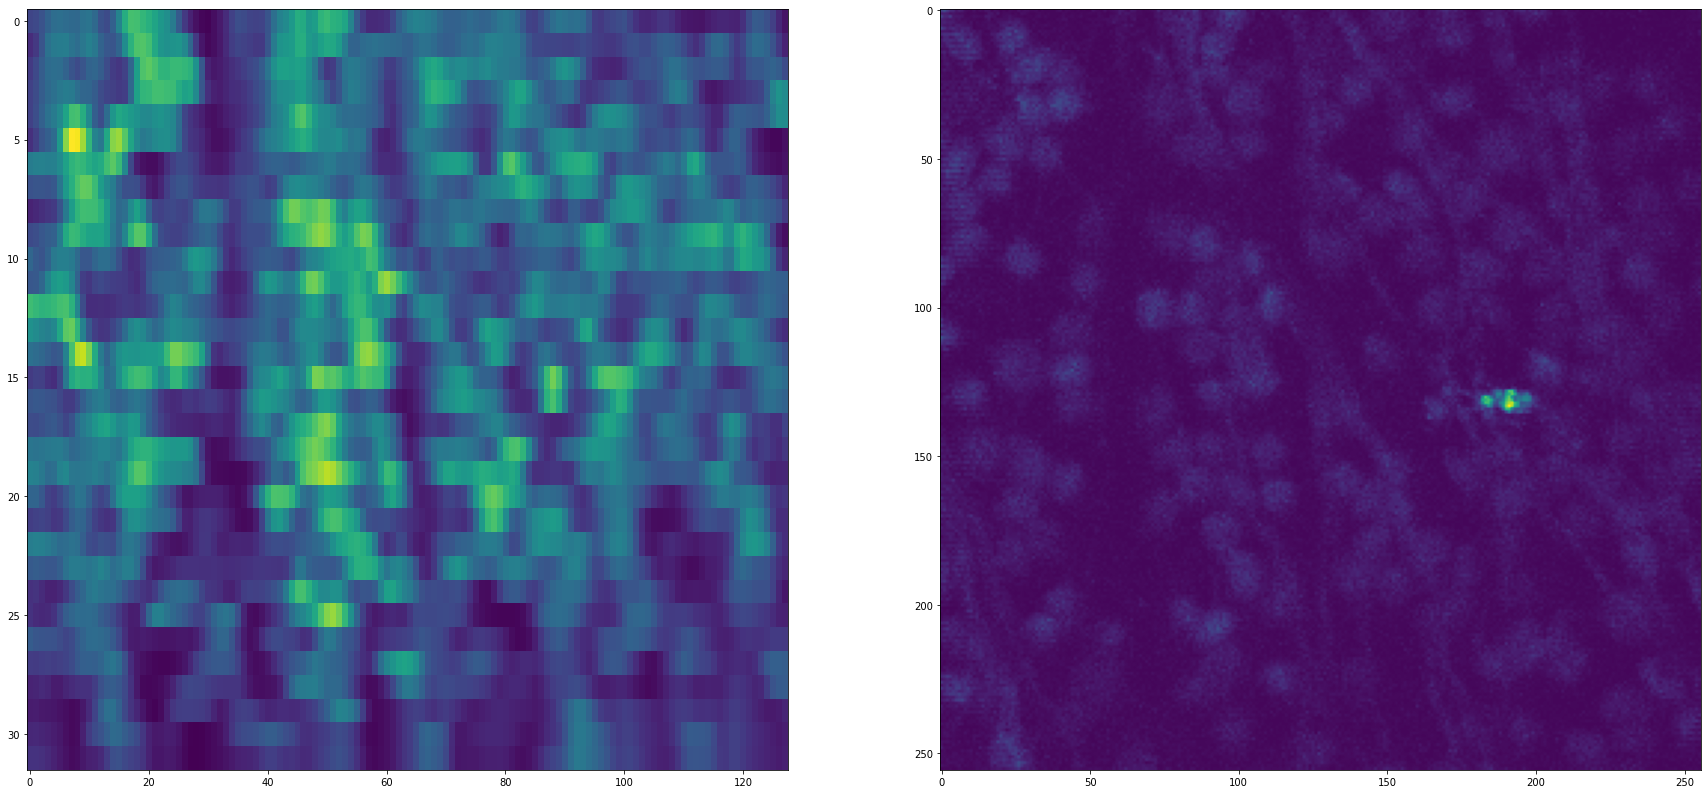

In [18]:
import suite2p
import os

_,axs = plt.subplots(1,2,figsize=(30,15))
axs[0].imshow(outputs[7], aspect=4, interpolation='nearest')

stack,_ = suite2p.io.tiff.open_tiff(stack_path[0],sktiff=0)
axs[1].imshow(stack.data()[28])

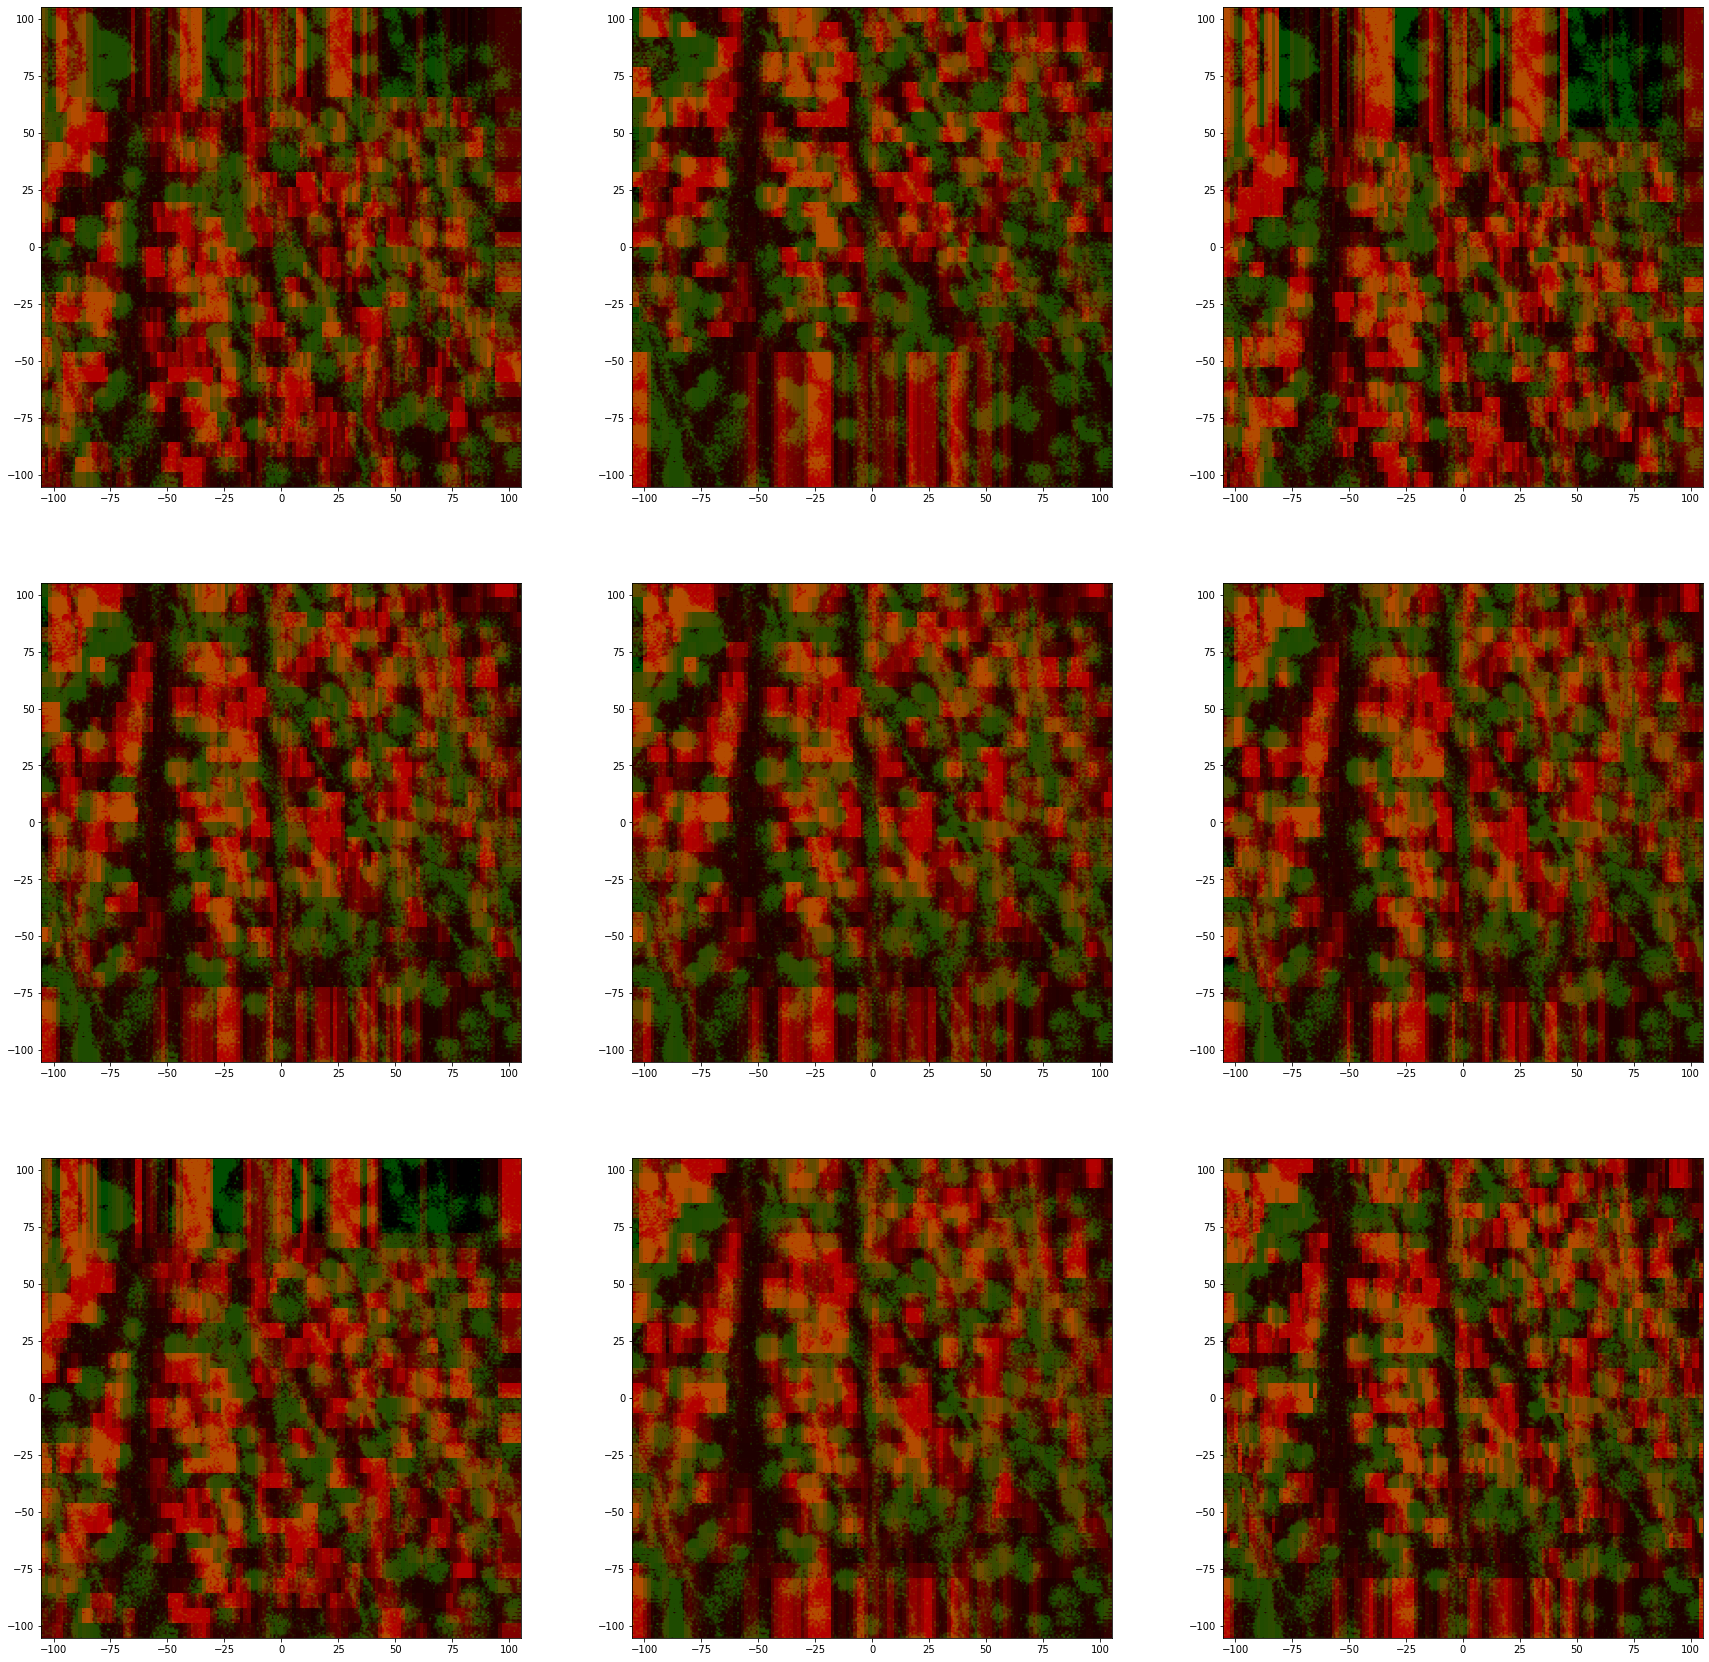

In [59]:
_,axs = plt.subplots(3,3,figsize=(30,30))
axs = axs.flatten()
for i in range(9):
    im = axs[i].imshow(
        suite2p.io.BinaryRWFile(32,128,os.path.join(out_path[0],'reg_chan2.bin')).data[i],
        # aspect=4, 
        cmap=LinearSegmentedColormap.from_list("Red", [(0,0,0), (1,0,0)]),
        extent=105.3*np.array([-1,1,-1,1]),
        )
    im.set_clim(-1500, 7000)

    im = axs[i].imshow(stack.data()[28], 
    cmap=LinearSegmentedColormap.from_list("Green", [(0,0,0), (0,1,0)]),
    alpha = .3,
    extent=105.3*np.array([-1,1,-1,1]))
    im.set_clim(100,500)
    # print(im.get_clim())
# plt.imshow(suite2p.io.BinaryRWFile(32,128,os.path.join(out_path[0],'reg_chan2.bin')).data.mean(axis=0), aspect=4)


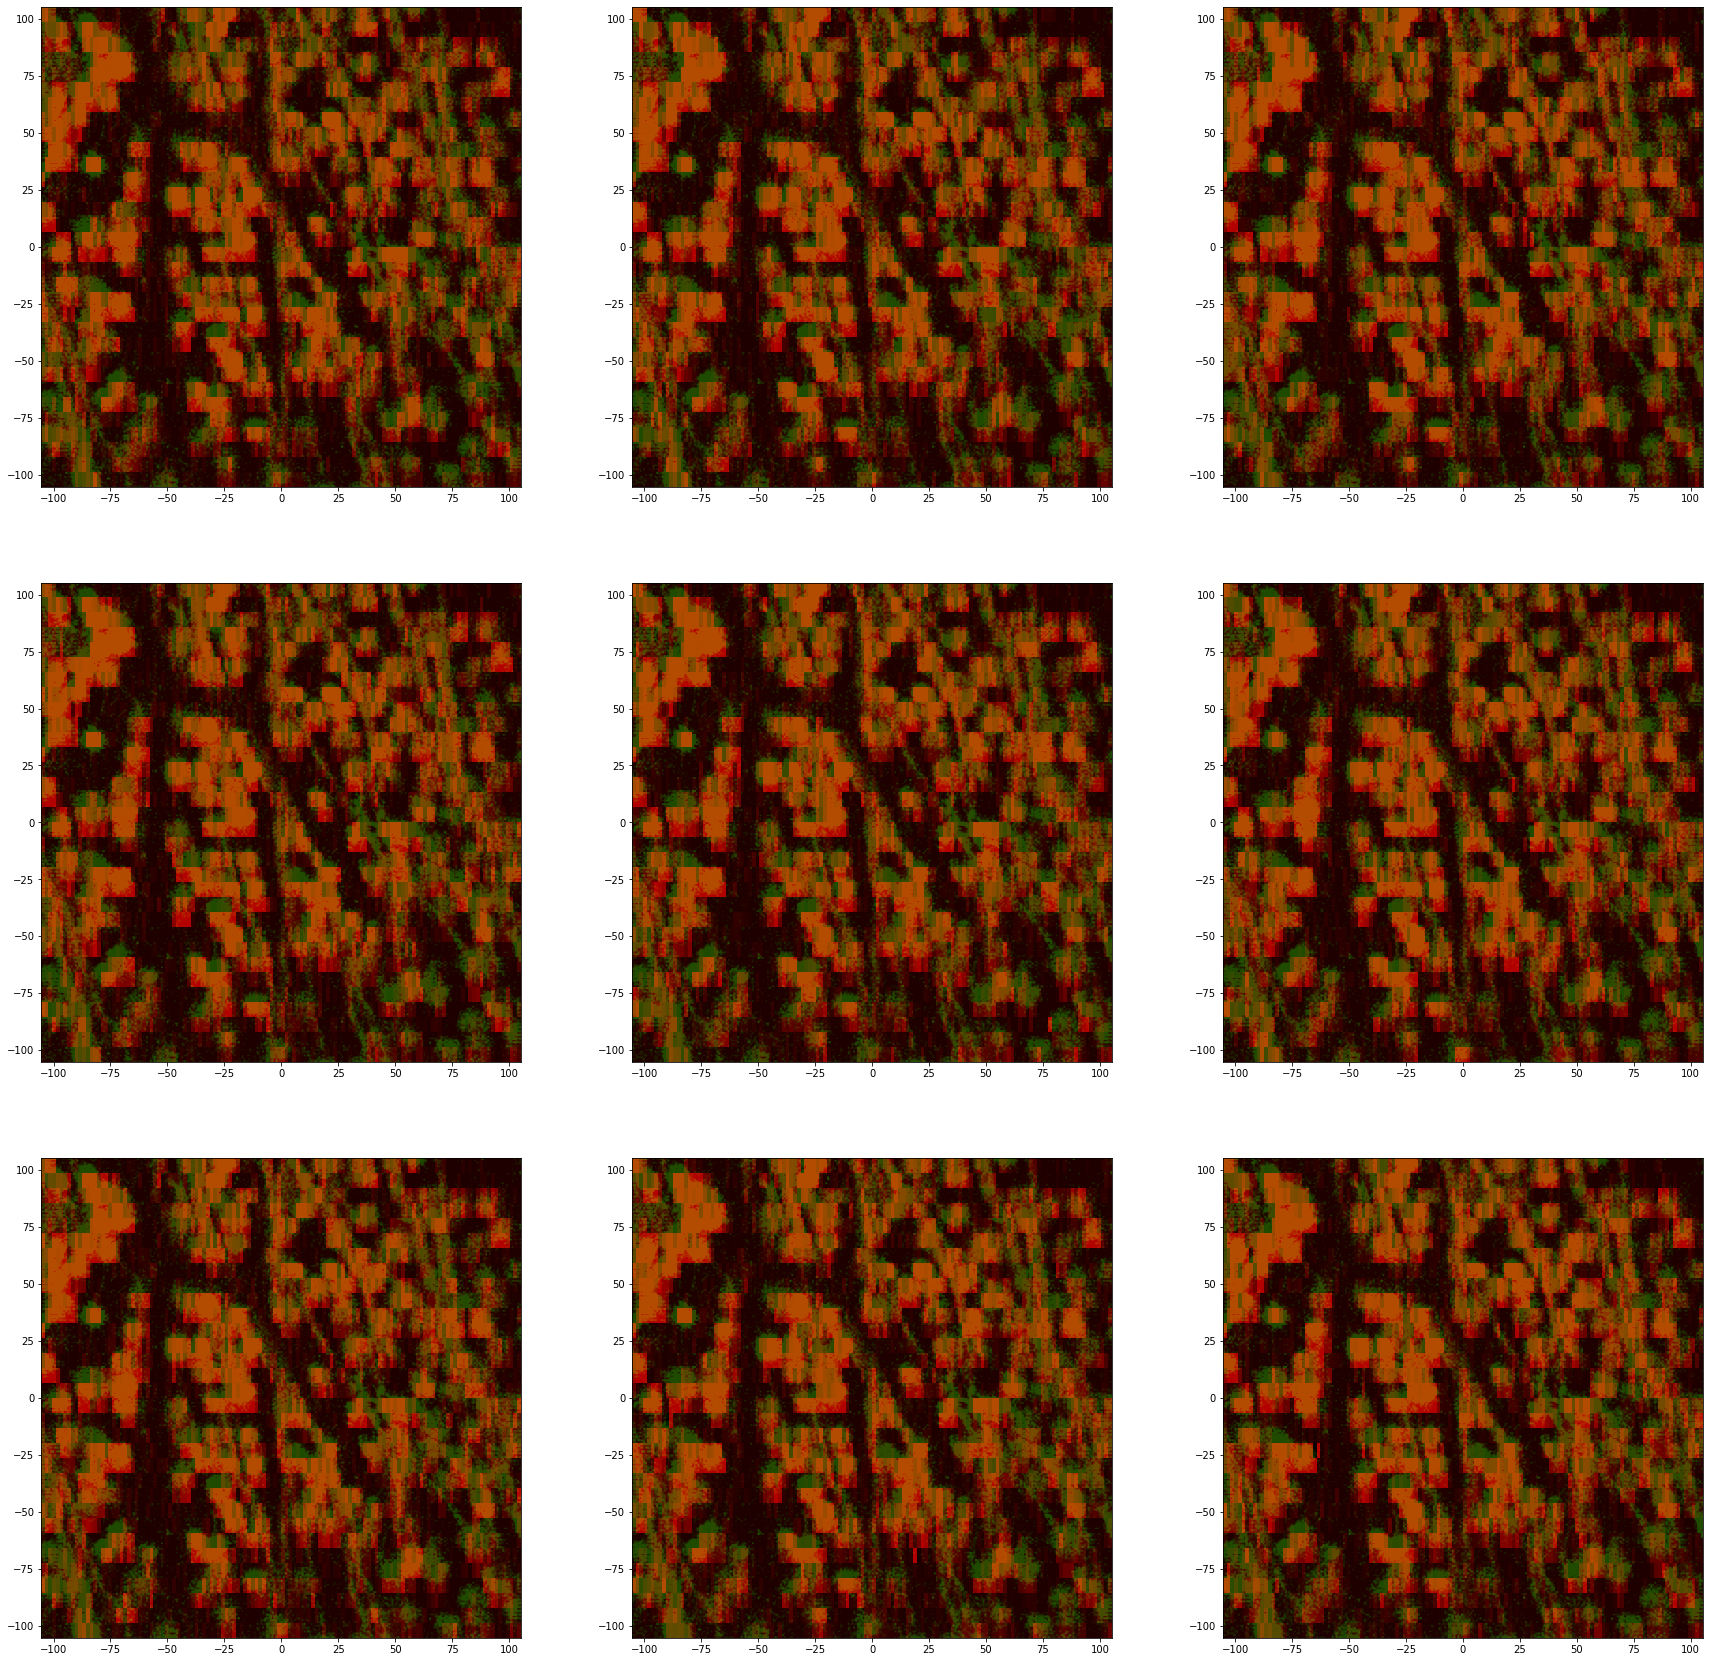

In [60]:
_,axs = plt.subplots(3,3,figsize=(30,30))
axs = axs.flatten()
for i in range(9):
    im = axs[i].imshow(
        suite2p.io.BinaryRWFile(32,128,os.path.join(out_path[0],'suite2p','plane0','data_chan2.bin')).data[i],
        # aspect=4, 
        cmap=LinearSegmentedColormap.from_list("Red", [(0,0,0), (1,0,0)]),
        extent=105.3*np.array([-1,1,-1,1]),
        )
    im.set_clim(-1500, 7000)

    im = axs[i].imshow(stack.data()[28], 
    cmap=LinearSegmentedColormap.from_list("Green", [(0,0,0), (0,1,0)]),
    alpha = .3,
    extent=105.3*np.array([-1,1,-1,1]))
    im.set_clim(100,500)
    # print(im.get_clim())
# plt.imshow(suite2p.io.BinaryRWFile(32,128,os.path.join(out_path[0],'reg_chan2.bin')).data.mean(axis=0), aspect=4)
